In [8]:
print("Importing...")
from pprint import pprint
import json
import sys
import os
from shutil import rmtree
from copy import deepcopy
from os.path import join
from importlib import reload

from os.path import isdir
from os.path import join
from os import mkdir
from shutil import rmtree

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras import losses
from keras import metrics
from keras import optimizers
from keras import layers
from keras import regularizers
import tensorflow_addons as tfa

sys.path.insert(0, os.path.join(os.getcwd(), "../scs"))
import scs_config as scsc
import data_loading as dl
import data_degrading as dd
import data_preparation as dp
import data_augmentation as da
import data_plotting as dplt
import learn
import lr_schedules
import hp_sets
# import prepare_dataset

# My packages
sys.path.insert(0, "../scs/")
from prepare_R_data import prepare_R_data
from data_loading import load_sn_data
from prepare_datasets_for_training import extract
from prepare_datasets_for_training import add_dim
from lr_schedules import get_lr_schedule
import data_plotting as dplt

sys.path.insert(0, "../scs/models")
import feed_forward
import transformer_encoder

Importing...


In [9]:
R = 100
data_dir_original = "/home/2649/repos/SCS/data/"
dir_models = "/lustre/lrspec/users/2649/models/transformer_testing"

# Construct the directories if they don't exist or delete them and recreate
# them if they do and `restart_fit` is `True`.
dir_model = join(dir_models, f"{R}_dev")
dir_backup = join(dir_model, "backup")
dir_model_data = join(dir_model, "data")
if isdir(dir_model):
    rmtree(dir_model)
mkdir(dir_model)
mkdir(dir_backup)
mkdir(dir_model_data)

file_trn = join(dir_model_data, f"sn_data_trn.RPA.parquet")
file_tst = join(dir_model_data, f"sn_data_tst.RP.parquet")

hp = deepcopy(scsc.default_hyper_parameters)

hp["train_frac"] = 0.80
hp["noise_scale"] = 0.15848931924611134
hp["spike_scale"] = 1.045639552591273
hp["max_spikes"] = 3

# Prepare the dataset from the original dataset dataframe `sn_data_file`.
sn_data_file = join(data_dir_original, "sn_data.parquet")
prepare_dataset.prepare_dataset(
    R,
    sn_data_file,
    dir_model_data,
    dir_model_data,
    dir_model_data,
    dir_model_data,
    hp["phase_range"],
    hp["ptp_range"],
    hp["wvl_range"],
    hp["train_frac"],
    hp["noise_scale"],
    hp["spike_scale"],
    hp["max_spikes"],
    random_state=hp["random_state"],
)

# Load the dataset.
df_trn = dl.load_sn_data(file_trn)
df_tst = dl.load_sn_data(file_tst)
dataset, num_wvl, num_classes = learn.prepare_datasets_for_training(
    df_trn, df_tst
)
Xtrn, Ytrn, Xtst, Ytst = dataset

NameError: name 'prepare_dataset' is not defined

In [5]:
hp

NameError: name 'hp' is not defined

In [28]:
input_shape = Xtrn.shape[1:]
model = get_model(input_shape, num_classes, hp)
model.summary()

compile_model(model, num_classes, hp["lr0"])
lr_schedule = get_lr_schedule(hp)
callbacks = get_callbacks(dir_model, lr_schedule)

history = train(
    model,
    Xtrn,
    Ytrn,
    Xtst,
    Ytst,
    hp["epochs"],
    hp["batch_size"],
    callbacks,
)

results = evaluate(model, Xtrn, Ytrn, Xtst, Ytst, verbose=0)
write_json(results, file_model_results)

log = pd.read_csv(file_model_history)
fig = dplt.plot_loss(log)
fig.savefig(file_model_curves)
fig.clf()


In [29]:
data = df.loc[:, df.columns[5:]].values

In [30]:
rng = np.random.RandomState(1415)

In [65]:
def add_noise(data, sigma, rng):
    noise = np.abs(rng.normal(loc=0, scale=sigma, size=data.shape))
    return noise

noise = add_noise(data, 0, rng)
data_noise = data + noise
wvl = df.columns[5:].values.astype(float)
flux = data[0]
flux -= flux.min()

# Advice from fed

In linear space, noise is a multiplicative factor. So I need to figure out a noise profile from each spectrum and scale it. Smooth the original spectrum, take the difference between the smoothed and the original spectrum, and then those residuals will be the noise profile (until we can talk to marc and get that code to extract noise profile more cleverly).

Can also do this additively in log space.

(<Figure size 1440x720 with 1 Axes>,
 <AxesSubplot:xlabel='Wavelength [$\\AA$]', ylabel='Normalized Flux [$F_{\\lambda}$]'>)

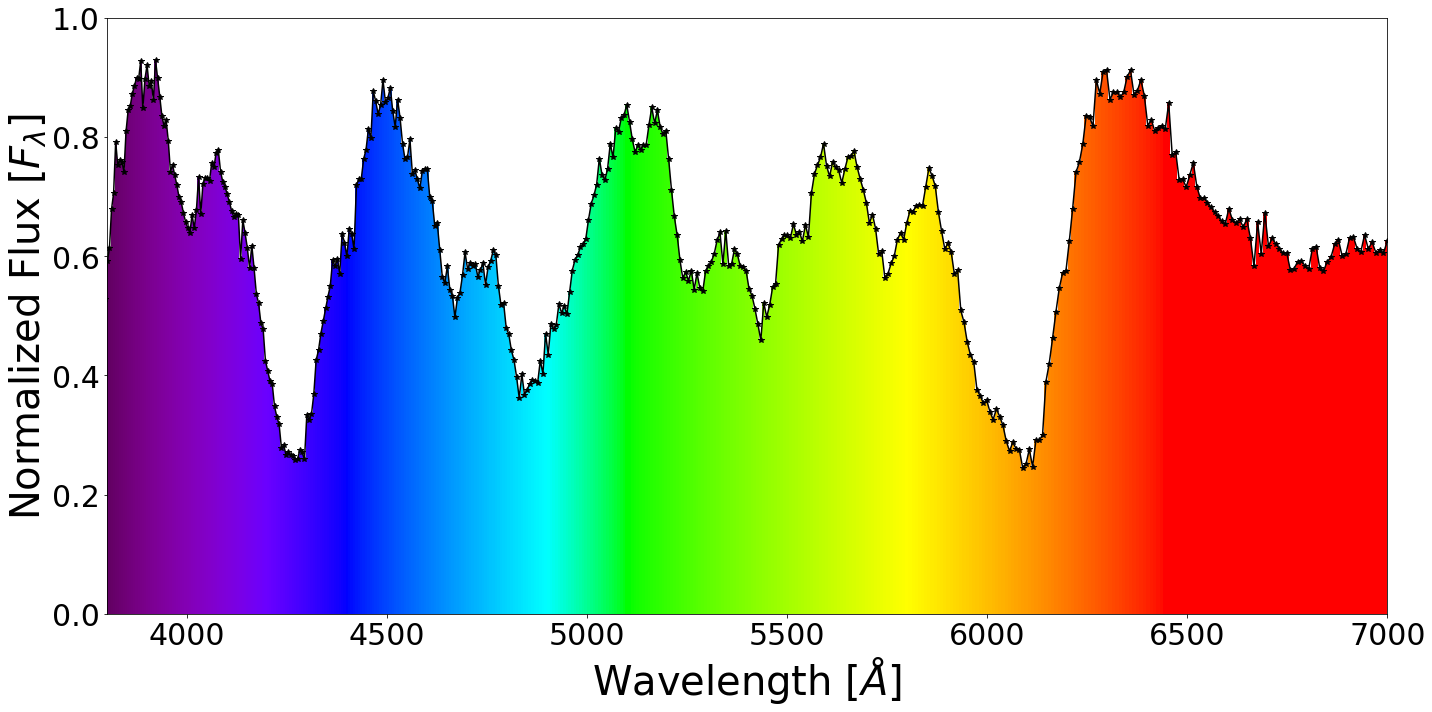

In [66]:
dplt.plotSpec(wvl, flux)